In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor

In [2]:
data = pd.read_csv('cleaned_property_data.csv')

In [3]:
categorical_features = ['TYPE', 'ZIPCODE', 'BOROUGH']
numeric_features = ['BEDS', 'BATH', 'PROPERTYSQFT', 'LATITUDE', 'LONGITUDE']

In [4]:
X = data[categorical_features + numeric_features]
y = data['PRICE']

In [5]:
# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [6]:
# Create a pipeline with preprocessor and LightGBM model
lgbm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(n_estimators=100, random_state=42))
])

In [7]:
# Split the data and train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 3068, number of used features: 78
[LightGBM] [Info] Start training from score 894822.311278


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['BEDS', 'BATH',
                                                   'PROPERTYSQFT', 'LATITUDE',
                                                   'LONGITUDE']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['TYPE', 'ZIPCODE',
                                                   'BOROUGH'])])),
                ('regressor', LGBMRegressor(random_state=42))])

In [8]:
# Calculate performance metrics
y_train_pred = lgbm_model.predict(X_train)
y_test_pred = lgbm_model.predict(X_test)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Calculate MAE as a percentage
avg_train_price = y_train.mean()
avg_test_price = y_test.mean()
train_mae_percent = (train_mae / avg_train_price) * 100
test_mae_percent = (test_mae / avg_test_price) * 100

print("Model Performance:")
print(f"Training R2 Score: {train_r2:.4f}")
print(f"Testing R2 Score: {test_r2:.4f}")
print(f"Training MAE: ${train_mae:,.2f} ({train_mae_percent:.2f}%)")
print(f"Testing MAE: ${test_mae:,.2f} ({test_mae_percent:.2f}%)")

Model Performance:
Training R2 Score: 0.8964
Testing R2 Score: 0.7196
Training MAE: $133,040.52 (14.87%)
Testing MAE: $204,088.55 (22.61%)


In [9]:
cv_scores = cross_val_score(lgbm_model, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R2 Scores: {cv_scores}")
print(f"Mean CV R2 Score: {np.mean(cv_scores)}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 938
[LightGBM] [Info] Number of data points in the train set: 3068, number of used features: 77
[LightGBM] [Info] Start training from score 909519.094524
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 937
[LightGBM] [Info] Number of data points in the train set: 3068, number of used features: 76
[LightGBM] [Info] Start training from score 909157.997718
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 934
[LightGBM] [Info] Number of data points in the train set: 3068, number of used features: 75
[LightGBM] [Info] Start

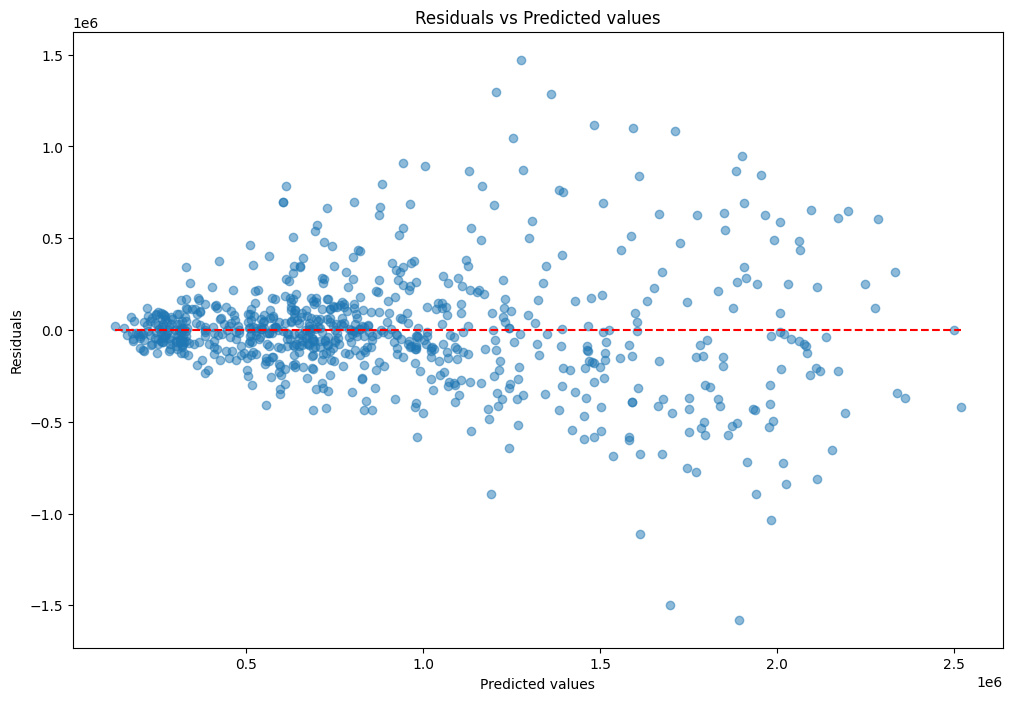

In [10]:
# Calculate residuals
residuals = y_test - y_test_pred

# Plot residuals vs predicted values
plt.figure(figsize=(12, 8))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_test_pred.min(), xmax=y_test_pred.max(), colors='red', linestyles='dashed')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values')
plt.show()

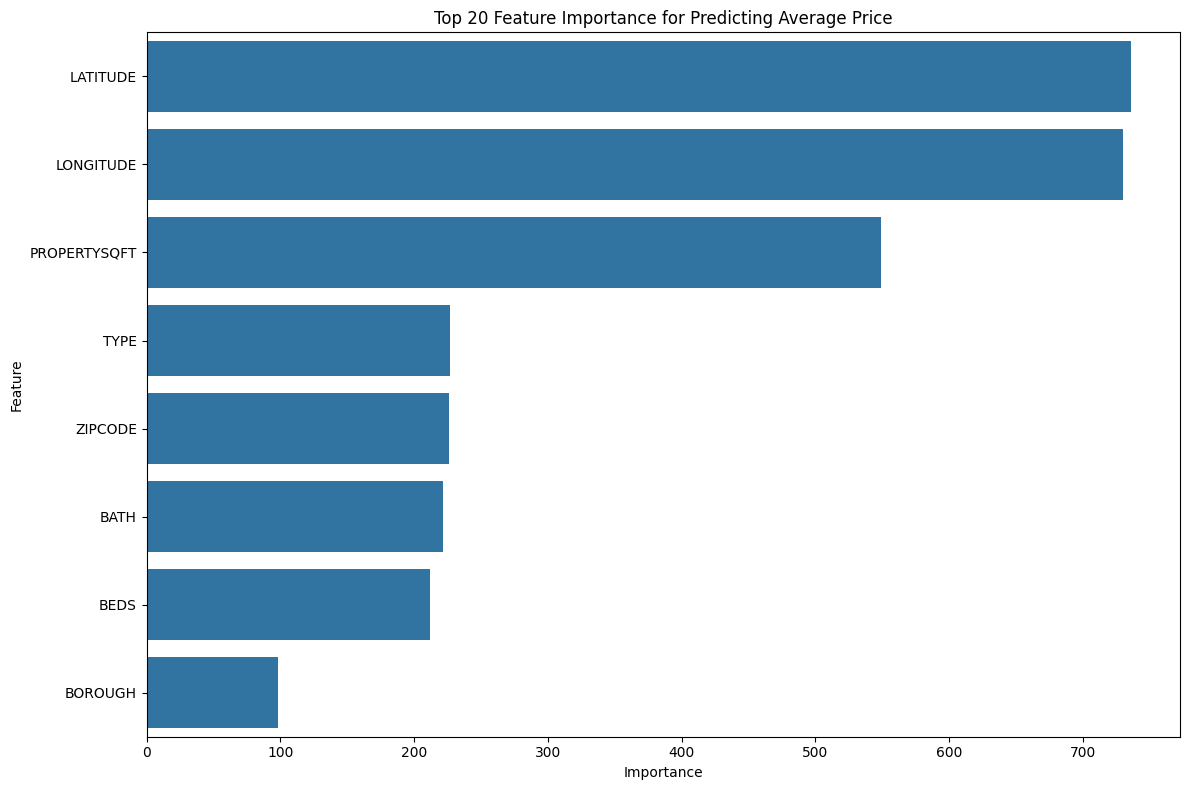

In [15]:
# Get feature names
numeric_features_names = numeric_features
categorical_features_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.array(numeric_features_names + list(categorical_features_names))

# Get feature importances from the random forest model
importances = lgbm_model.named_steps['regressor'].feature_importances_

# Aggregate importances for categorical variables
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance['feature'] = feature_importance['feature'].apply(lambda x: x.split('_')[0] if '_' in x else x)
feature_importance = feature_importance.groupby('feature').sum().reset_index()
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Plot top 20 feature importances
top_n = 20
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(top_n))
plt.title('Top 20 Feature Importance for Predicting Average Price')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [16]:
# Print feature importances
print("Feature Importances:")
print(feature_importance)

Feature Importances:
        feature  importance
3      LATITUDE         736
4     LONGITUDE         730
5  PROPERTYSQFT         549
6          TYPE         227
7       ZIPCODE         226
0          BATH         222
1          BEDS         212
2       BOROUGH          98
